In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import visdom

import mxnet as mx
from mxnet import gluon
from mxnet import autograd
from mxnet import image

import sys
sys.path.append('../../resuneta/src')
sys.path.append('../../decode/FracTAL_ResUNet/models/semanticsegmentation')
sys.path.append('../../decode/FracTAL_ResUNet/nn/loss')
sys.path.append('../../')
sys.path.append('../MXNet-ResUNeta/')

from bound_dist import get_distance, get_boundary
from FracTAL_ResUNet import FracTAL_ResUNet_cmtsk
from ftnmt_loss import ftnmt_loss_masked
from datasets import *

from sklearn.metrics import matthews_corrcoef

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def dice_coef(x, y):
    if type(x).__module__ == 'numpy':
        intersection = np.logical_and(x, y)
        return 2. * np.sum(intersection) / (np.sum(x) + np.sum(y))
    else:
        intersection = mx.ndarray.op.broadcast_logical_and(x, y)
        return 2. * mx.nd.sum(intersection) / (mx.nd.sum(x) + mx.nd.sum(y))

In [4]:
def visdom_visualize_batch(vis, img, extent, boundary, distance,
                           extent_pred, boundary_pred, distance_pred,
                           hsv, hsv_pred, mask, title="Train images"):

    img, extent, boundary, distance = img.asnumpy(), extent.asnumpy(), boundary.asnumpy(), distance.asnumpy()
    extent_pred, boundary_pred = extent_pred.asnumpy(), boundary_pred.asnumpy()
    distance_pred, hsv, hsv_pred = distance_pred.asnumpy(), hsv.asnumpy(), hsv_pred.asnumpy()
    mask = mask.asnumpy()

    # put everything in one window
    batch_size, nchannels, nrows, ncols = img.shape
    padding = 10
    items = [img, hsv, hsv_pred, extent, extent_pred, 
             boundary, boundary_pred, distance, distance_pred,
             mask]
    result = np.zeros((3, len(items)*nrows + (len(items)-1)*padding, batch_size*ncols + (batch_size-1)*padding))

    for j, item in enumerate(items):

        if item.shape[1] == 1:
            item = np.tile(item, (1,3,1,1)) * 255.

        if j == 1 or j == 2: # convert HSV to RGB
            item = np.moveaxis(item, 1, -1) * 255.
            for i in range(batch_size):
                item[i] = cv2.cvtColor(item[i].astype(np.uint8), cv2.COLOR_HSV2RGB)
            item = np.moveaxis(item, -1, 1)
            
        for i in range(batch_size):
            result[:, j*(nrows+padding):(j+1)*nrows+j*padding, i*(ncols+padding):(i+1)*ncols+i*padding] = item[i]
    vis.images(result, nrow=1, win=title, opts={'title': title})


In [5]:
def train_model(train_dataloader, model, tanimoto_dual, trainer, epoch, args):
    
    # initialize metrics
    cumulative_loss = 0
    accuracy = mx.metric.Accuracy()
    f1 = mx.metric.F1()
    mcc = mx.metric.MCC()
    dice = mx.metric.CustomMetric(feval=dice_coef, name="Dice")
    if args['ctx_name'] == 'cpu':
        ctx = mx.cpu()
    else:
        ctx = mx.gpu(args['gpu'])
    
    # training set
    for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(
        tqdm(train_dataloader, desc='Training epoch {}'.format(epoch))):
        
        with autograd.record():

            img = img.as_in_context(ctx)
            extent = extent.as_in_context(ctx)
            boundary = boundary.as_in_context(ctx)
            distance = distance.as_in_context(ctx)
            hsv = hsv.as_in_context(ctx)
            mask = mask.as_in_context(ctx)
            nonmask = mx.nd.ones(extent.shape).as_in_context(ctx)
            
            # logits, bound, dist, convc = model(img)
            logits, bound, dist = model(img)
            
            # multi-task loss
            # TODO: wrap this in a custom loss function / class
            loss_extent = mx.nd.sum(tanimoto_dual(logits, extent, mask))
            loss_boundary = mx.nd.sum(tanimoto_dual(bound, boundary, mask))
            loss_distance = mx.nd.sum(tanimoto_dual(dist, distance, mask))

            loss = 0.33 * (loss_extent + loss_boundary + loss_distance) # + loss_hsv)
            
        loss.backward()
        trainer.step(args['batch_size'])
        cumulative_loss += mx.nd.sum(loss).asscalar()
        
        logits_reshaped = logits.reshape((logits.shape[0], -1))
        extent_reshaped = extent.reshape((extent.shape[0], -1))
        mask_reshaped = mask.reshape((mask.shape[0], -1))
        
        nonmask_idx = mx.np.nonzero(mask_reshaped.as_np_ndarray())
        nonmask_idx = mx.np.stack(nonmask_idx).as_nd_ndarray().as_in_context(ctx)
        logits_masked = mx.nd.gather_nd(logits_reshaped, nonmask_idx)
        extent_masked = mx.nd.gather_nd(extent_reshaped, nonmask_idx)

        # accuracy
        extent_predicted_classes = mx.nd.ceil(logits_masked - 0.5)
        accuracy.update(extent_masked, extent_predicted_classes)
        
        # f1 score
        probabilities = mx.nd.stack(1 - logits_masked, logits_masked, axis=1)
        f1.update(extent_masked, probabilities)
        
        # MCC metric
        mcc.update(extent_masked, probabilities)
        
        # Dice score
        dice.update(extent_masked, extent_predicted_classes)
        
        # TEMPORARY to make visdom work
        convc = hsv
        if batch_i % args['visdom_every'] == 0:
            visdom_visualize_batch(args['visdom'], img, extent, boundary, distance,
                                   logits, bound, dist, hsv, convc, mask)

    return cumulative_loss, accuracy, f1, mcc, dice

In [6]:
def evaluate_model(val_dataloader, model, tanimoto_dual, epoch, args):
    
    # initialize metrics
    cumulative_loss = 0
    accuracy = mx.metric.Accuracy()
    f1 = mx.metric.F1()
    mcc = mx.metric.MCC()
    dice = mx.metric.CustomMetric(feval=dice_coef, name="Dice")
    if args['ctx_name'] == 'cpu':
        ctx = mx.cpu()
    else:
        ctx = mx.gpu(args['gpu'])
    
    # validation set
    for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(
        tqdm(val_dataloader, desc='Validation epoch {}'.format(epoch))):

        img = img.as_in_context(ctx)
        extent = extent.as_in_context(ctx)
        boundary = boundary.as_in_context(ctx)
        distance = distance.as_in_context(ctx)
        hsv = hsv.as_in_context(ctx)
        mask = mask.as_in_context(ctx)
        nonmask = mx.nd.ones(extent.shape).as_in_context(ctx)

        # logits, bound, dist, convc = model(img)
        logits, bound, dist = model(img)
        
        # multi-task loss
        # TODO: wrap this in a custom loss function / class
        loss_extent = mx.nd.sum(tanimoto_dual(logits, extent, mask))
        loss_boundary = mx.nd.sum(tanimoto_dual(bound, boundary, mask))
        loss_distance = mx.nd.sum(tanimoto_dual(dist, distance, mask))

        loss = 0.33 * (loss_extent + loss_boundary + loss_distance) # + loss_hsv)
        
        # update metrics based on every batch
        cumulative_loss += mx.nd.sum(loss).asscalar()
        
        # update metrics based on every batch
        # mask out unlabeled pixels            
        logits_reshaped = logits.reshape((logits.shape[0], -1))
        extent_reshaped = extent.reshape((extent.shape[0], -1))
        mask_reshaped = mask.reshape((mask.shape[0], -1))
        
        nonmask_idx = mx.np.nonzero(mask_reshaped.as_np_ndarray())
        nonmask_idx = mx.np.stack(nonmask_idx).as_nd_ndarray().as_in_context(ctx)
        logits_masked = mx.nd.gather_nd(logits_reshaped, nonmask_idx)
        extent_masked = mx.nd.gather_nd(extent_reshaped, nonmask_idx)

        # accuracy
        extent_predicted_classes = mx.nd.ceil(logits_masked - 0.5)
        accuracy.update(extent_masked, extent_predicted_classes)
        
        # f1 score
        probabilities = mx.nd.stack(1 - logits_masked, logits_masked, axis=1)
        f1.update(extent_masked, probabilities)
        
        # MCC metric
        mcc.update(extent_masked, probabilities)
        
        # Dice score
        dice.update(extent_masked, extent_predicted_classes)
        
        # TEMPORARY to make visdom work
        convc = hsv
        if batch_i % args['visdom_every'] == 0:
            visdom_visualize_batch(args['visdom'], img, extent, boundary, distance,
                                   logits, bound, dist, hsv, convc, mask, title="Val images")
        
    return cumulative_loss, accuracy, f1, mcc, dice

# Africa datasets

In [7]:
def run_africa(country, train_names, val_names, test_names, 
               train_names_label, val_names_label, test_names_label,
               trained_model=None, month='Airbus',
               epochs=100, lr=0.001, lr_decay=None, n_filters=16, batch_size=8,
               model_type='fractal-resunet', depth=5, n_classes=1, 
               codes_to_keep=[1, 2],
               folder_suffix='',
               boundary_kernel_size=3,
               ctx_name='cpu',
               gpu_id=0):
    
    # Set MXNet ctx
    if ctx_name == 'cpu':
        ctx = mx.cpu()
    elif ctx_name == 'gpu':
        ctx = mx.gpu(gpu_id)
    
    # Set up names of directories and paths for saving
    if trained_model is None:
        folder_name = model_type+'_'+month+'_nfilter-'+str(n_filters)+'_depth-'+str(depth)+ \
                      '_bs-'+str(batch_size)+'_lr-'+str(lr)+folder_suffix
        if lr_decay:
            folder_name = folder_name + '_lrdecay-'+str(lr_decay)
            
        # define model
        if model_type == 'resunet-d6':
            model = ResUNet_d6(_nfilters_init=n_filters, _NClasses=n_classes)
        elif model_type == 'resunet-d7':
            model = ResUNet_d7(_nfilters_init=n_filters, _NClasses=n_classes)
        elif model_type == 'fractal-resunet':
            model = FracTAL_ResUNet_cmtsk(nfilters_init=n_filters, depth=depth, NClasses=n_classes)
        model.initialize()
        model.hybridize()
        model.collect_params().reset_ctx(ctx)
        
    else:
        folder_name = model_type+'_'+month+'_nfilter-'+str(n_filters)+'_depth-'+str(depth)+ \
                      '_bs-'+str(batch_size)+'_lr-'+str(lr)+folder_suffix
        if model_type == 'resunet-d6':
            model = ResUNet_d6(_nfilters_init=n_filters, _NClasses=n_classes)
        elif model_type == 'resunet-d7':
            model = ResUNet_d7(_nfilters_init=n_filters, _NClasses=n_classes)
        elif model_type == 'fractal-resunet':
            model = FracTAL_ResUNet_cmtsk(nfilters_init=n_filters, depth=depth, NClasses=n_classes)
        model.load_parameters(trained_model, ctx=ctx)
        
    save_path = os.path.join('../experiments/', country, folder_name)
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    save_model_name = os.path.join(save_path, "model.params")
    
    # Visdom
    env_name = country + '_' + folder_name
    vis = visdom.Visdom(port=8097, env=env_name)
    
    # Arguments
    args = {}
    args['batch_size'] = batch_size
    args['ctx_name'] = ctx_name
    args['gpu'] = gpu_id
    args['visdom'] = vis
    args['visdom_every'] = 20

    # Define train/val/test splits
    train_dataset = AirbusMasked(
        fold='train', 
        image_names=train_names, 
        label_names=train_names_label, 
        classes=codes_to_keep,
        boundary_kernel_size=boundary_kernel_size)
    val_dataset = AirbusMasked(
        fold='val', 
        image_names=val_names, 
        label_names=val_names_label, 
        classes=codes_to_keep,
        boundary_kernel_size=boundary_kernel_size)
    test_dataset = AirbusMasked(
        fold='test', 
        image_names=test_names, 
        label_names=test_names_label, 
        classes=codes_to_keep,
        boundary_kernel_size=boundary_kernel_size)

    train_dataloader = gluon.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = gluon.data.DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = gluon.data.DataLoader(test_dataset, batch_size=batch_size)

    # define loss function
    tanimoto_dual = ftnmt_loss_masked(depth=0) # Tanimoto_with_dual_masked()
    if lr_decay:
        schedule = mx.lr_scheduler.FactorScheduler(step=1, factor=lr_decay)
        adam_optimizer = mx.optimizer.Adam(learning_rate=lr, lr_scheduler=schedule)
    else:
        adam_optimizer = mx.optimizer.Adam(learning_rate=lr)
    trainer = gluon.Trainer(model.collect_params(), optimizer=adam_optimizer)

    # containers for metrics to log
    train_metrics = {'train_loss': [], 'train_acc': [], 'train_f1': [], 
                     'train_mcc': [], 'train_dice': []}
    val_metrics = {'val_loss': [], 'val_acc': [], 'val_f1': [], 
                   'val_mcc': [], 'val_dice': []}
    best_mcc = 0.0

    # training loop
    for epoch in range(1, epochs+1):

        # training set
        train_loss, train_accuracy, train_f1, train_mcc, train_dice = train_model(
            train_dataloader, model, tanimoto_dual, trainer, epoch, args)

        # training set metrics
        train_loss_avg = train_loss / len(train_dataset)
        train_metrics['train_loss'].append(train_loss_avg)
        train_metrics['train_acc'].append(train_accuracy.get()[1])
        train_metrics['train_f1'].append(train_f1.get()[1])
        train_metrics['train_mcc'].append(train_mcc.get()[1])
        train_metrics['train_dice'].append(train_dice.get()[1])

        # validation set
        val_loss, val_accuracy, val_f1, val_mcc, val_dice = evaluate_model(
            val_dataloader, model, tanimoto_dual, epoch, args)

        # validation set metrics
        val_loss_avg = val_loss / len(val_dataset)
        val_metrics['val_loss'].append(val_loss_avg)
        val_metrics['val_acc'].append(val_accuracy.get()[1])
        val_metrics['val_f1'].append(val_f1.get()[1])
        val_metrics['val_mcc'].append(val_mcc.get()[1])
        val_metrics['val_dice'].append(val_dice.get()[1])

        print("Epoch {}:".format(epoch))
        print("    Train loss {:0.3f}, accuracy {:0.3f}, F1-score {:0.3f}, MCC: {:0.3f}, Dice: {:0.3f}".format(
            train_loss_avg, train_accuracy.get()[1], train_f1.get()[1], train_mcc.get()[1], train_dice.get()[1]))
        print("    Val loss {:0.3f}, accuracy {:0.3f}, F1-score {:0.3f}, MCC: {:0.3f}, Dice: {:0.3f}".format(
            val_loss_avg, val_accuracy.get()[1], val_f1.get()[1], val_mcc.get()[1], val_dice.get()[1]))

        # save model based on best MCC metric
        if val_mcc.get()[1] > best_mcc:
            model.save_parameters(save_model_name)
            best_mcc = val_mcc.get()[1]

        # save metrics
        metrics = pd.concat([pd.DataFrame(train_metrics), pd.DataFrame(val_metrics)], axis=1)
        metrics.to_csv(os.path.join(save_path, 'metrics.csv'), index=False)

        # visdom
        vis.line(Y=np.stack([train_metrics['train_loss'], val_metrics['val_loss']], axis=1), 
                 X=np.arange(1, epoch+1), win="Loss", 
                 opts=dict(legend=['train loss', 'val loss'], markers=False, title="Losses",
                           xlabel="Epoch", ylabel="Loss")
                )
        vis.line(Y=np.stack([train_metrics['train_mcc'], val_metrics['val_mcc']], axis=1), 
                 X=np.arange(1, epoch+1), win="MCC", 
                 opts=dict(legend=['train MCC', 'val MCC'], markers=False, title="MCC",
                           xlabel="Epoch", ylabel="MCC")
                )


Start Visdom!

In [8]:
# ============================ #
# user-specified hyperparameters
# ============================ #
country = 'india'
epochs = 100
lr = 0.001
lr_decay = None
n_filters = 32
depth = 6
n_classes = 1
batch_size = 5
model_type = 'fractal-resunet' # 'resunet-d6'
month = 'all13'
codes_to_keep = [1]
ctx_name = 'gpu'
gpu_id = 3
boundary_kernel_size = (2,2)

# trained_model = '../experiments/partial-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/model.params'
trained_model = '../experiments/india/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_3x-downsampled-erosion2px_n100_fromscratch/model.params'
# trained_model = None

folder_suffix = '_3x-downsampled-erosion2px_n100'
if trained_model is None:
    folder_suffix += '_fromscratch'
elif 'india' in trained_model:
    folder_suffix += '_fromscratch-continued'
elif 'france' in trained_model:
    folder_suffix += '_finetuned'
    
month_name = 'Airbus'
# splits_path = '../data/splits/india_planetImagery_splits_20x20_v2.csv'
splits_path = '../data/splits/india_planetImagery_splits_20x20_n100.csv'
splits_df = pd.read_csv(splits_path, dtype=str)
splits_df['image_id'] = splits_df['image_id'].str[:4]
splits_df = splits_df.drop_duplicates('image_id')
# splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(5)

# get all img and labels
all_img_names = []
all_label_names = []
# img_dir = '../data/general_blockchain/airbus_false_color/campaign1/'
# label_dir = '../data/general_blockchain/airbus_labels/campaign1/'
img_dir = '../data/general_blockchain/airbus_false_color/large/3x_downsample/'
label_dir = '../data/general_blockchain/airbus_labels/large/3x_downsample_erosion2px/'

label_folder_imgs = sorted(os.listdir(label_dir))
for label_name in label_folder_imgs:
    img_name = 'airbus_geowiki_' + label_name.split('_')[-1].split('.')[0] + '.png'
    img_path = os.path.join(img_dir, img_name)
    all_img_names.append(img_path)
    label_path = os.path.join(label_dir, label_name)
    all_label_names.append(label_path)
    
# split imgs and labels into train/val/test
all_images = pd.DataFrame({'img_path': all_img_names})
all_images['image_id'] = all_images['img_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[-1][1:])
all_images = all_images.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
train_names = all_images[all_images['fold'] == 'train']['img_path'].values
val_names = all_images[all_images['fold'] == 'val']['img_path'].values
test_names = all_images[all_images['fold'] == 'test']['img_path'].values

all_labels = pd.DataFrame({'label_path': all_label_names})
all_labels['image_id'] = all_labels['label_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[-1][1:])
all_labels = all_labels.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
train_names_label = all_labels[all_labels['fold'] == 'train']['label_path'].values
val_names_label = all_labels[all_labels['fold'] == 'val']['label_path'].values
test_names_label = all_labels[all_labels['fold'] == 'test']['label_path'].values

# ============================ #

run_africa(country, train_names, val_names, test_names,
           train_names_label, val_names_label, test_names_label,
           trained_model=trained_model,
           epochs=epochs, lr=lr, lr_decay=lr_decay, 
           model_type=model_type, n_filters=n_filters, depth=depth, n_classes=n_classes,
           batch_size=batch_size, month=month_name,
           codes_to_keep=codes_to_keep, 
           ctx_name=ctx_name,
           gpu_id=gpu_id, 
           folder_suffix=folder_suffix,
           boundary_kernel_size=boundary_kernel_size)

depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1


Setting up a new session...
Validation epoch 1: 100%|██████████| 27/27 [00:13<00:00,  1.95it/s]


Epoch 1:
    Train loss 0.302, accuracy 0.814, F1-score 0.864, MCC: 0.495, Dice: 0.864
    Val loss 0.300, accuracy 0.809, F1-score 0.874, MCC: 0.456, Dice: 0.874


Validation epoch 2: 100%|██████████| 27/27 [00:14<00:00,  1.88it/s]


Epoch 2:
    Train loss 0.281, accuracy 0.814, F1-score 0.861, MCC: 0.523, Dice: 0.861
    Val loss 0.301, accuracy 0.807, F1-score 0.869, MCC: 0.471, Dice: 0.869


Training epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3:
    Train loss 0.277, accuracy 0.817, F1-score 0.875, MCC: 0.512, Dice: 0.875
    Val loss 0.310, accuracy 0.812, F1-score 0.876, MCC: 0.434, Dice: 0.876


Training epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4:
    Train loss 0.276, accuracy 0.823, F1-score 0.881, MCC: 0.535, Dice: 0.881
    Val loss 0.295, accuracy 0.827, F1-score 0.885, MCC: 0.467, Dice: 0.885


Training epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5:
    Train loss 0.285, accuracy 0.811, F1-score 0.871, MCC: 0.520, Dice: 0.871
    Val loss 0.305, accuracy 0.820, F1-score 0.883, MCC: 0.441, Dice: 0.883


Validation epoch 6: 100%|██████████| 27/27 [00:15<00:00,  1.72it/s]


Epoch 6:
    Train loss 0.280, accuracy 0.820, F1-score 0.872, MCC: 0.525, Dice: 0.872
    Val loss 0.300, accuracy 0.820, F1-score 0.879, MCC: 0.475, Dice: 0.879


Validation epoch 7: 100%|██████████| 27/27 [00:16<00:00,  1.68it/s]


Epoch 7:
    Train loss 0.277, accuracy 0.815, F1-score 0.875, MCC: 0.527, Dice: 0.875
    Val loss 0.298, accuracy 0.810, F1-score 0.871, MCC: 0.489, Dice: 0.871


Training epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8:
    Train loss 0.277, accuracy 0.824, F1-score 0.880, MCC: 0.526, Dice: 0.880
    Val loss 0.312, accuracy 0.788, F1-score 0.854, MCC: 0.450, Dice: 0.854


Training epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9:
    Train loss 0.269, accuracy 0.824, F1-score 0.878, MCC: 0.556, Dice: 0.878
    Val loss 0.298, accuracy 0.806, F1-score 0.867, MCC: 0.471, Dice: 0.867


Training epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10:
    Train loss 0.272, accuracy 0.822, F1-score 0.871, MCC: 0.522, Dice: 0.871
    Val loss 0.295, accuracy 0.811, F1-score 0.873, MCC: 0.478, Dice: 0.873


Training epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11:
    Train loss 0.285, accuracy 0.819, F1-score 0.874, MCC: 0.505, Dice: 0.874
    Val loss 0.301, accuracy 0.818, F1-score 0.878, MCC: 0.462, Dice: 0.878


Training epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12:
    Train loss 0.276, accuracy 0.821, F1-score 0.872, MCC: 0.541, Dice: 0.872
    Val loss 0.300, accuracy 0.813, F1-score 0.876, MCC: 0.464, Dice: 0.876


Training epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13:
    Train loss 0.276, accuracy 0.828, F1-score 0.874, MCC: 0.543, Dice: 0.874
    Val loss 0.302, accuracy 0.803, F1-score 0.867, MCC: 0.452, Dice: 0.867


Training epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14:
    Train loss 0.278, accuracy 0.818, F1-score 0.875, MCC: 0.523, Dice: 0.875
    Val loss 0.299, accuracy 0.841, F1-score 0.897, MCC: 0.450, Dice: 0.897


Training epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15:
    Train loss 0.273, accuracy 0.815, F1-score 0.867, MCC: 0.533, Dice: 0.867
    Val loss 0.325, accuracy 0.743, F1-score 0.823, MCC: 0.425, Dice: 0.823


Validation epoch 16: 100%|██████████| 27/27 [00:17<00:00,  1.53it/s]


Epoch 16:
    Train loss 0.273, accuracy 0.815, F1-score 0.873, MCC: 0.517, Dice: 0.873
    Val loss 0.294, accuracy 0.802, F1-score 0.865, MCC: 0.490, Dice: 0.865


Training epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17:
    Train loss 0.262, accuracy 0.832, F1-score 0.879, MCC: 0.548, Dice: 0.879
    Val loss 0.291, accuracy 0.820, F1-score 0.878, MCC: 0.475, Dice: 0.878


Training epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18:
    Train loss 0.278, accuracy 0.806, F1-score 0.862, MCC: 0.522, Dice: 0.862
    Val loss 0.308, accuracy 0.805, F1-score 0.867, MCC: 0.455, Dice: 0.867


Validation epoch 19: 100%|██████████| 27/27 [00:16<00:00,  1.63it/s]


Epoch 19:
    Train loss 0.273, accuracy 0.829, F1-score 0.872, MCC: 0.537, Dice: 0.872
    Val loss 0.278, accuracy 0.837, F1-score 0.889, MCC: 0.516, Dice: 0.889


Training epoch 21:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20:
    Train loss 0.279, accuracy 0.825, F1-score 0.879, MCC: 0.524, Dice: 0.879
    Val loss 0.290, accuracy 0.831, F1-score 0.886, MCC: 0.470, Dice: 0.886


Training epoch 22:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21:
    Train loss 0.269, accuracy 0.828, F1-score 0.880, MCC: 0.541, Dice: 0.880
    Val loss 0.299, accuracy 0.795, F1-score 0.861, MCC: 0.443, Dice: 0.861


Training epoch 23:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22:
    Train loss 0.264, accuracy 0.821, F1-score 0.872, MCC: 0.543, Dice: 0.872
    Val loss 0.292, accuracy 0.821, F1-score 0.882, MCC: 0.486, Dice: 0.882


Training epoch 24:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23:
    Train loss 0.264, accuracy 0.830, F1-score 0.883, MCC: 0.546, Dice: 0.883
    Val loss 0.286, accuracy 0.826, F1-score 0.883, MCC: 0.498, Dice: 0.883


Training epoch 25:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24:
    Train loss 0.267, accuracy 0.826, F1-score 0.880, MCC: 0.550, Dice: 0.880
    Val loss 0.289, accuracy 0.843, F1-score 0.896, MCC: 0.482, Dice: 0.896


Training epoch 26:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25:
    Train loss 0.275, accuracy 0.818, F1-score 0.869, MCC: 0.519, Dice: 0.869
    Val loss 0.293, accuracy 0.823, F1-score 0.877, MCC: 0.480, Dice: 0.877


Training epoch 27:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26:
    Train loss 0.274, accuracy 0.822, F1-score 0.873, MCC: 0.522, Dice: 0.873
    Val loss 0.282, accuracy 0.819, F1-score 0.875, MCC: 0.502, Dice: 0.875


Training epoch 28:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27:
    Train loss 0.262, accuracy 0.835, F1-score 0.879, MCC: 0.531, Dice: 0.879
    Val loss 0.282, accuracy 0.834, F1-score 0.890, MCC: 0.508, Dice: 0.890


Training epoch 29:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28:
    Train loss 0.263, accuracy 0.825, F1-score 0.877, MCC: 0.552, Dice: 0.877
    Val loss 0.284, accuracy 0.836, F1-score 0.892, MCC: 0.483, Dice: 0.892


Training epoch 30:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29:
    Train loss 0.269, accuracy 0.826, F1-score 0.872, MCC: 0.526, Dice: 0.872
    Val loss 0.295, accuracy 0.834, F1-score 0.892, MCC: 0.446, Dice: 0.892


Training epoch 31:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30:
    Train loss 0.267, accuracy 0.820, F1-score 0.874, MCC: 0.538, Dice: 0.874
    Val loss 0.281, accuracy 0.835, F1-score 0.890, MCC: 0.492, Dice: 0.890


Training epoch 32:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31:
    Train loss 0.264, accuracy 0.826, F1-score 0.880, MCC: 0.548, Dice: 0.880
    Val loss 0.291, accuracy 0.828, F1-score 0.884, MCC: 0.469, Dice: 0.884


Training epoch 33:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 32:
    Train loss 0.275, accuracy 0.824, F1-score 0.868, MCC: 0.539, Dice: 0.868
    Val loss 0.306, accuracy 0.838, F1-score 0.897, MCC: 0.417, Dice: 0.897


Training epoch 34:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 33:
    Train loss 0.263, accuracy 0.837, F1-score 0.884, MCC: 0.561, Dice: 0.884
    Val loss 0.300, accuracy 0.827, F1-score 0.886, MCC: 0.474, Dice: 0.886


Training epoch 35:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 34:
    Train loss 0.263, accuracy 0.823, F1-score 0.874, MCC: 0.539, Dice: 0.874
    Val loss 0.287, accuracy 0.824, F1-score 0.881, MCC: 0.478, Dice: 0.881


Training epoch 36:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35:
    Train loss 0.270, accuracy 0.830, F1-score 0.880, MCC: 0.546, Dice: 0.880
    Val loss 0.300, accuracy 0.813, F1-score 0.871, MCC: 0.467, Dice: 0.871


Training epoch 37:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 36:
    Train loss 0.265, accuracy 0.824, F1-score 0.879, MCC: 0.544, Dice: 0.879
    Val loss 0.301, accuracy 0.805, F1-score 0.869, MCC: 0.465, Dice: 0.869


Training epoch 38:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 37:
    Train loss 0.264, accuracy 0.814, F1-score 0.871, MCC: 0.528, Dice: 0.871
    Val loss 0.301, accuracy 0.820, F1-score 0.885, MCC: 0.460, Dice: 0.885


Training epoch 39:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 38:
    Train loss 0.260, accuracy 0.820, F1-score 0.873, MCC: 0.540, Dice: 0.873
    Val loss 0.303, accuracy 0.818, F1-score 0.882, MCC: 0.455, Dice: 0.882


Training epoch 40:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39:
    Train loss 0.258, accuracy 0.827, F1-score 0.878, MCC: 0.542, Dice: 0.878
    Val loss 0.294, accuracy 0.813, F1-score 0.875, MCC: 0.472, Dice: 0.875


Training epoch 41:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 40:
    Train loss 0.269, accuracy 0.813, F1-score 0.866, MCC: 0.534, Dice: 0.866
    Val loss 0.290, accuracy 0.807, F1-score 0.872, MCC: 0.488, Dice: 0.872


Training epoch 42:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 41:
    Train loss 0.257, accuracy 0.831, F1-score 0.877, MCC: 0.555, Dice: 0.877
    Val loss 0.278, accuracy 0.828, F1-score 0.886, MCC: 0.500, Dice: 0.886


Training epoch 43:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 42:
    Train loss 0.258, accuracy 0.835, F1-score 0.883, MCC: 0.568, Dice: 0.883
    Val loss 0.291, accuracy 0.814, F1-score 0.871, MCC: 0.464, Dice: 0.871


Training epoch 44:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 43:
    Train loss 0.259, accuracy 0.842, F1-score 0.880, MCC: 0.571, Dice: 0.880
    Val loss 0.291, accuracy 0.830, F1-score 0.886, MCC: 0.467, Dice: 0.886


Training epoch 45:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 44:
    Train loss 0.256, accuracy 0.822, F1-score 0.874, MCC: 0.546, Dice: 0.874
    Val loss 0.290, accuracy 0.825, F1-score 0.887, MCC: 0.477, Dice: 0.887


Training epoch 46:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 45:
    Train loss 0.257, accuracy 0.839, F1-score 0.887, MCC: 0.553, Dice: 0.887
    Val loss 0.282, accuracy 0.821, F1-score 0.881, MCC: 0.495, Dice: 0.881


Training epoch 47:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 46:
    Train loss 0.263, accuracy 0.833, F1-score 0.882, MCC: 0.550, Dice: 0.882
    Val loss 0.294, accuracy 0.800, F1-score 0.863, MCC: 0.463, Dice: 0.863


Training epoch 48:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 47:
    Train loss 0.258, accuracy 0.830, F1-score 0.883, MCC: 0.557, Dice: 0.883
    Val loss 0.293, accuracy 0.808, F1-score 0.870, MCC: 0.466, Dice: 0.870


Training epoch 49:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 48:
    Train loss 0.260, accuracy 0.823, F1-score 0.881, MCC: 0.552, Dice: 0.881
    Val loss 0.293, accuracy 0.813, F1-score 0.871, MCC: 0.485, Dice: 0.871


Training epoch 50:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 49:
    Train loss 0.260, accuracy 0.817, F1-score 0.878, MCC: 0.541, Dice: 0.878
    Val loss 0.294, accuracy 0.835, F1-score 0.890, MCC: 0.470, Dice: 0.890


Training epoch 51:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 50:
    Train loss 0.263, accuracy 0.840, F1-score 0.885, MCC: 0.571, Dice: 0.885
    Val loss 0.296, accuracy 0.831, F1-score 0.888, MCC: 0.460, Dice: 0.888


Training epoch 52:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 51:
    Train loss 0.262, accuracy 0.838, F1-score 0.879, MCC: 0.561, Dice: 0.879
    Val loss 0.293, accuracy 0.804, F1-score 0.868, MCC: 0.480, Dice: 0.868


Training epoch 53:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 52:
    Train loss 0.251, accuracy 0.829, F1-score 0.876, MCC: 0.554, Dice: 0.876
    Val loss 0.289, accuracy 0.824, F1-score 0.881, MCC: 0.477, Dice: 0.881


Training epoch 54:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 53:
    Train loss 0.256, accuracy 0.835, F1-score 0.880, MCC: 0.566, Dice: 0.880
    Val loss 0.304, accuracy 0.802, F1-score 0.861, MCC: 0.452, Dice: 0.861


Training epoch 55:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 54:
    Train loss 0.249, accuracy 0.836, F1-score 0.886, MCC: 0.567, Dice: 0.886
    Val loss 0.280, accuracy 0.825, F1-score 0.882, MCC: 0.507, Dice: 0.882


Training epoch 56:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 55:
    Train loss 0.260, accuracy 0.831, F1-score 0.865, MCC: 0.548, Dice: 0.865
    Val loss 0.299, accuracy 0.783, F1-score 0.851, MCC: 0.440, Dice: 0.851


Training epoch 57:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 56:
    Train loss 0.260, accuracy 0.823, F1-score 0.874, MCC: 0.528, Dice: 0.874
    Val loss 0.301, accuracy 0.793, F1-score 0.860, MCC: 0.446, Dice: 0.860


Training epoch 58:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 57:
    Train loss 0.251, accuracy 0.838, F1-score 0.884, MCC: 0.563, Dice: 0.884
    Val loss 0.291, accuracy 0.822, F1-score 0.877, MCC: 0.475, Dice: 0.877


Training epoch 59:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 58:
    Train loss 0.253, accuracy 0.834, F1-score 0.884, MCC: 0.570, Dice: 0.884
    Val loss 0.293, accuracy 0.846, F1-score 0.898, MCC: 0.454, Dice: 0.898


Training epoch 60:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 59:
    Train loss 0.261, accuracy 0.822, F1-score 0.870, MCC: 0.542, Dice: 0.870
    Val loss 0.290, accuracy 0.831, F1-score 0.885, MCC: 0.496, Dice: 0.885


Training epoch 61:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 60:
    Train loss 0.256, accuracy 0.831, F1-score 0.887, MCC: 0.561, Dice: 0.887
    Val loss 0.293, accuracy 0.812, F1-score 0.872, MCC: 0.475, Dice: 0.872


Training epoch 62:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 61:
    Train loss 0.248, accuracy 0.834, F1-score 0.886, MCC: 0.553, Dice: 0.886
    Val loss 0.285, accuracy 0.826, F1-score 0.885, MCC: 0.495, Dice: 0.885


Training epoch 63:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 62:
    Train loss 0.258, accuracy 0.829, F1-score 0.878, MCC: 0.554, Dice: 0.878
    Val loss 0.289, accuracy 0.818, F1-score 0.880, MCC: 0.474, Dice: 0.880


Training epoch 64:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 63:
    Train loss 0.249, accuracy 0.826, F1-score 0.871, MCC: 0.552, Dice: 0.871
    Val loss 0.292, accuracy 0.794, F1-score 0.860, MCC: 0.480, Dice: 0.860


Training epoch 65:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 64:
    Train loss 0.254, accuracy 0.825, F1-score 0.879, MCC: 0.546, Dice: 0.879
    Val loss 0.293, accuracy 0.819, F1-score 0.878, MCC: 0.464, Dice: 0.878


Training epoch 66:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 65:
    Train loss 0.256, accuracy 0.837, F1-score 0.882, MCC: 0.566, Dice: 0.882
    Val loss 0.304, accuracy 0.840, F1-score 0.895, MCC: 0.464, Dice: 0.895


Training epoch 67:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 66:
    Train loss 0.253, accuracy 0.839, F1-score 0.886, MCC: 0.565, Dice: 0.886
    Val loss 0.290, accuracy 0.836, F1-score 0.888, MCC: 0.471, Dice: 0.888


Training epoch 68:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 67:
    Train loss 0.247, accuracy 0.836, F1-score 0.885, MCC: 0.575, Dice: 0.885
    Val loss 0.289, accuracy 0.811, F1-score 0.871, MCC: 0.461, Dice: 0.871


Training epoch 69:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 68:
    Train loss 0.246, accuracy 0.838, F1-score 0.883, MCC: 0.547, Dice: 0.883
    Val loss 0.300, accuracy 0.805, F1-score 0.862, MCC: 0.450, Dice: 0.862


Training epoch 70:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 69:
    Train loss 0.251, accuracy 0.834, F1-score 0.885, MCC: 0.561, Dice: 0.885
    Val loss 0.285, accuracy 0.819, F1-score 0.877, MCC: 0.498, Dice: 0.877


Training epoch 71:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 70:
    Train loss 0.247, accuracy 0.837, F1-score 0.880, MCC: 0.560, Dice: 0.880
    Val loss 0.278, accuracy 0.833, F1-score 0.887, MCC: 0.492, Dice: 0.887


Training epoch 72:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 71:
    Train loss 0.248, accuracy 0.842, F1-score 0.889, MCC: 0.575, Dice: 0.889
    Val loss 0.293, accuracy 0.830, F1-score 0.885, MCC: 0.456, Dice: 0.885


Training epoch 73:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 72:
    Train loss 0.250, accuracy 0.825, F1-score 0.882, MCC: 0.564, Dice: 0.882
    Val loss 0.280, accuracy 0.836, F1-score 0.888, MCC: 0.499, Dice: 0.888


Training epoch 74:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 73:
    Train loss 0.253, accuracy 0.839, F1-score 0.884, MCC: 0.569, Dice: 0.884
    Val loss 0.291, accuracy 0.844, F1-score 0.899, MCC: 0.462, Dice: 0.899


Training epoch 75:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 74:
    Train loss 0.249, accuracy 0.833, F1-score 0.880, MCC: 0.558, Dice: 0.880
    Val loss 0.286, accuracy 0.820, F1-score 0.878, MCC: 0.471, Dice: 0.878


Training epoch 76:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 75:
    Train loss 0.251, accuracy 0.848, F1-score 0.897, MCC: 0.591, Dice: 0.897
    Val loss 0.294, accuracy 0.805, F1-score 0.869, MCC: 0.461, Dice: 0.869


Training epoch 77:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 76:
    Train loss 0.249, accuracy 0.837, F1-score 0.879, MCC: 0.574, Dice: 0.879
    Val loss 0.278, accuracy 0.826, F1-score 0.882, MCC: 0.503, Dice: 0.882


Training epoch 78:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 77:
    Train loss 0.237, accuracy 0.853, F1-score 0.897, MCC: 0.592, Dice: 0.897
    Val loss 0.291, accuracy 0.823, F1-score 0.880, MCC: 0.463, Dice: 0.880


Training epoch 79:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 78:
    Train loss 0.245, accuracy 0.830, F1-score 0.883, MCC: 0.570, Dice: 0.883
    Val loss 0.280, accuracy 0.843, F1-score 0.897, MCC: 0.490, Dice: 0.897


Training epoch 80:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 79:
    Train loss 0.254, accuracy 0.835, F1-score 0.886, MCC: 0.575, Dice: 0.886
    Val loss 0.290, accuracy 0.824, F1-score 0.883, MCC: 0.467, Dice: 0.883


Training epoch 81:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 80:
    Train loss 0.237, accuracy 0.849, F1-score 0.895, MCC: 0.584, Dice: 0.895
    Val loss 0.287, accuracy 0.814, F1-score 0.874, MCC: 0.469, Dice: 0.874


Training epoch 82:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 81:
    Train loss 0.247, accuracy 0.829, F1-score 0.883, MCC: 0.562, Dice: 0.883
    Val loss 0.284, accuracy 0.813, F1-score 0.874, MCC: 0.474, Dice: 0.874


Training epoch 83:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 82:
    Train loss 0.260, accuracy 0.830, F1-score 0.872, MCC: 0.554, Dice: 0.872
    Val loss 0.306, accuracy 0.819, F1-score 0.880, MCC: 0.433, Dice: 0.880


Training epoch 84:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 83:
    Train loss 0.245, accuracy 0.844, F1-score 0.881, MCC: 0.564, Dice: 0.881
    Val loss 0.282, accuracy 0.816, F1-score 0.880, MCC: 0.499, Dice: 0.880


Training epoch 85:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 84:
    Train loss 0.241, accuracy 0.850, F1-score 0.898, MCC: 0.591, Dice: 0.898
    Val loss 0.287, accuracy 0.809, F1-score 0.872, MCC: 0.477, Dice: 0.872


Training epoch 86:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 85:
    Train loss 0.244, accuracy 0.840, F1-score 0.886, MCC: 0.571, Dice: 0.886
    Val loss 0.290, accuracy 0.818, F1-score 0.875, MCC: 0.477, Dice: 0.875


Training epoch 87:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 86:
    Train loss 0.258, accuracy 0.838, F1-score 0.884, MCC: 0.568, Dice: 0.884
    Val loss 0.289, accuracy 0.829, F1-score 0.885, MCC: 0.497, Dice: 0.885


Training epoch 88:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 87:
    Train loss 0.252, accuracy 0.824, F1-score 0.873, MCC: 0.561, Dice: 0.873
    Val loss 0.303, accuracy 0.829, F1-score 0.887, MCC: 0.438, Dice: 0.887


Training epoch 89:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 88:
    Train loss 0.241, accuracy 0.838, F1-score 0.880, MCC: 0.581, Dice: 0.880
    Val loss 0.307, accuracy 0.786, F1-score 0.854, MCC: 0.468, Dice: 0.854


Training epoch 90:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 89:
    Train loss 0.240, accuracy 0.842, F1-score 0.891, MCC: 0.573, Dice: 0.891
    Val loss 0.284, accuracy 0.822, F1-score 0.880, MCC: 0.490, Dice: 0.880


Training epoch 91:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 90:
    Train loss 0.239, accuracy 0.848, F1-score 0.892, MCC: 0.577, Dice: 0.892
    Val loss 0.278, accuracy 0.812, F1-score 0.872, MCC: 0.498, Dice: 0.872


Training epoch 92:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 91:
    Train loss 0.244, accuracy 0.840, F1-score 0.890, MCC: 0.580, Dice: 0.890
    Val loss 0.284, accuracy 0.801, F1-score 0.866, MCC: 0.489, Dice: 0.866


Training epoch 93:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 92:
    Train loss 0.240, accuracy 0.828, F1-score 0.880, MCC: 0.561, Dice: 0.880
    Val loss 0.284, accuracy 0.816, F1-score 0.875, MCC: 0.494, Dice: 0.875


Training epoch 94:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 93:
    Train loss 0.252, accuracy 0.836, F1-score 0.889, MCC: 0.571, Dice: 0.889
    Val loss 0.292, accuracy 0.826, F1-score 0.880, MCC: 0.470, Dice: 0.880


Training epoch 95:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 94:
    Train loss 0.246, accuracy 0.844, F1-score 0.892, MCC: 0.570, Dice: 0.892
    Val loss 0.292, accuracy 0.832, F1-score 0.888, MCC: 0.471, Dice: 0.888


Training epoch 96:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 95:
    Train loss 0.241, accuracy 0.844, F1-score 0.888, MCC: 0.572, Dice: 0.888
    Val loss 0.281, accuracy 0.839, F1-score 0.890, MCC: 0.507, Dice: 0.890


Training epoch 97:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 96:
    Train loss 0.244, accuracy 0.819, F1-score 0.878, MCC: 0.563, Dice: 0.878
    Val loss 0.288, accuracy 0.802, F1-score 0.863, MCC: 0.475, Dice: 0.863


Training epoch 98:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 97:
    Train loss 0.242, accuracy 0.843, F1-score 0.892, MCC: 0.581, Dice: 0.892
    Val loss 0.287, accuracy 0.819, F1-score 0.876, MCC: 0.479, Dice: 0.876


Training epoch 99:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 98:
    Train loss 0.242, accuracy 0.849, F1-score 0.895, MCC: 0.588, Dice: 0.895
    Val loss 0.287, accuracy 0.823, F1-score 0.882, MCC: 0.457, Dice: 0.882


Training epoch 100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 99:
    Train loss 0.253, accuracy 0.841, F1-score 0.879, MCC: 0.574, Dice: 0.879
    Val loss 0.277, accuracy 0.824, F1-score 0.886, MCC: 0.498, Dice: 0.886


Validation epoch 100: 100%|██████████| 27/27 [00:13<00:00,  1.98it/s]

Epoch 100:
    Train loss 0.235, accuracy 0.845, F1-score 0.884, MCC: 0.588, Dice: 0.884
    Val loss 0.288, accuracy 0.820, F1-score 0.876, MCC: 0.474, Dice: 0.876


In [26]:
img = imageio.imread('../data/general_blockchain/airbus_false_color/large/3x_downsample/airbus_geowiki_C1302.png')

In [24]:
img.shape

(1548, 1557, 3)

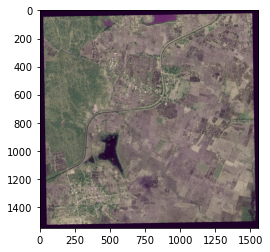

In [25]:
plt.imshow(img)
plt.show()

In [27]:
img.shape

(519, 516, 3)

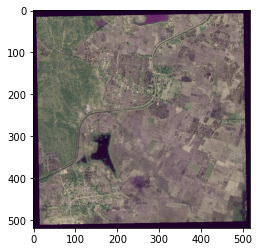

In [10]:
plt.imshow(img)
plt.show()

In [36]:
label = imageio.imread('../data/general_blockchain/airbus_labels/large/3x_downsample_erosion1px/airbus_geowiki_C1302.png')

In [37]:
label.shape

(519, 516)

In [34]:
label_orig = imageio.imread('../data/general_blockchain/airbus_labels/large/erosion1px/airbus_geowiki_C1302.png')

In [35]:
label_orig.shape

(1548, 1557)